In [2]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
import statsmodels.formula.api as sm
from sklearn.decomposition import PCA
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Hand cleansed market list
Hand cleaned to removed duplicates.  

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

In [5]:
FF_daily=pd.read_csv('FF.csv',parse_dates=['Date'],index_col=0)
FF_monthly=FF_daily.resample(rule='m',how='sum')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  from IPython.kernel.zmq import kernelapp as app


# Run Fama Macbeth regressions 

Then correlation matrix 
* Market factor (using Kenneth French's Mkt-Rf' factor on webpage
* Market illiquidity (median Amihud through time series on futures data


In [67]:
factors=pd.DataFrame()
factors['Median Illiquidity']=amihud.median(axis=1).dropna()*1e10
factors['Mkt-Rf']=FF_monthly['Mkt-RF']
factor_names = factors.columns
factors['Intercept']=1
ind=factors.index

In [68]:
data=cleansed.resample(rule='m',how='last').pct_change().ix[ind]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


First pass (Time Series Regression)

* Estimate betas from the factors

In [69]:
param={}
for f in factors.columns:
    param[f]=pd.Series()
for m in data.columns:
    ind=data[m].dropna().index
    res=sm.OLS(data[m].ix[ind],factors.ix[ind]).fit()
    for f in factors.columns:
        param[f][m]=res.params[f]
beta_hat=pd.DataFrame(param)
beta_hat['Intercept']=1

In [70]:
param={}
for f in factors.index:
    param[f]=pd.Series()
for t in factors.index:
    ind=data.T[t].dropna().index
    res=sm.OLS(data[ind].T[t].T,beta_hat.T[ind].T).fit()
    for f in factors.columns:
        param[t][f]=res.params[f]
lambda_hat=pd.DataFrame(param).T

In [71]:
lambda_hat.mean()*12

Median Illiquidity    7.726089
Mkt-Rf               -0.770660
Intercept             0.060998
dtype: float64

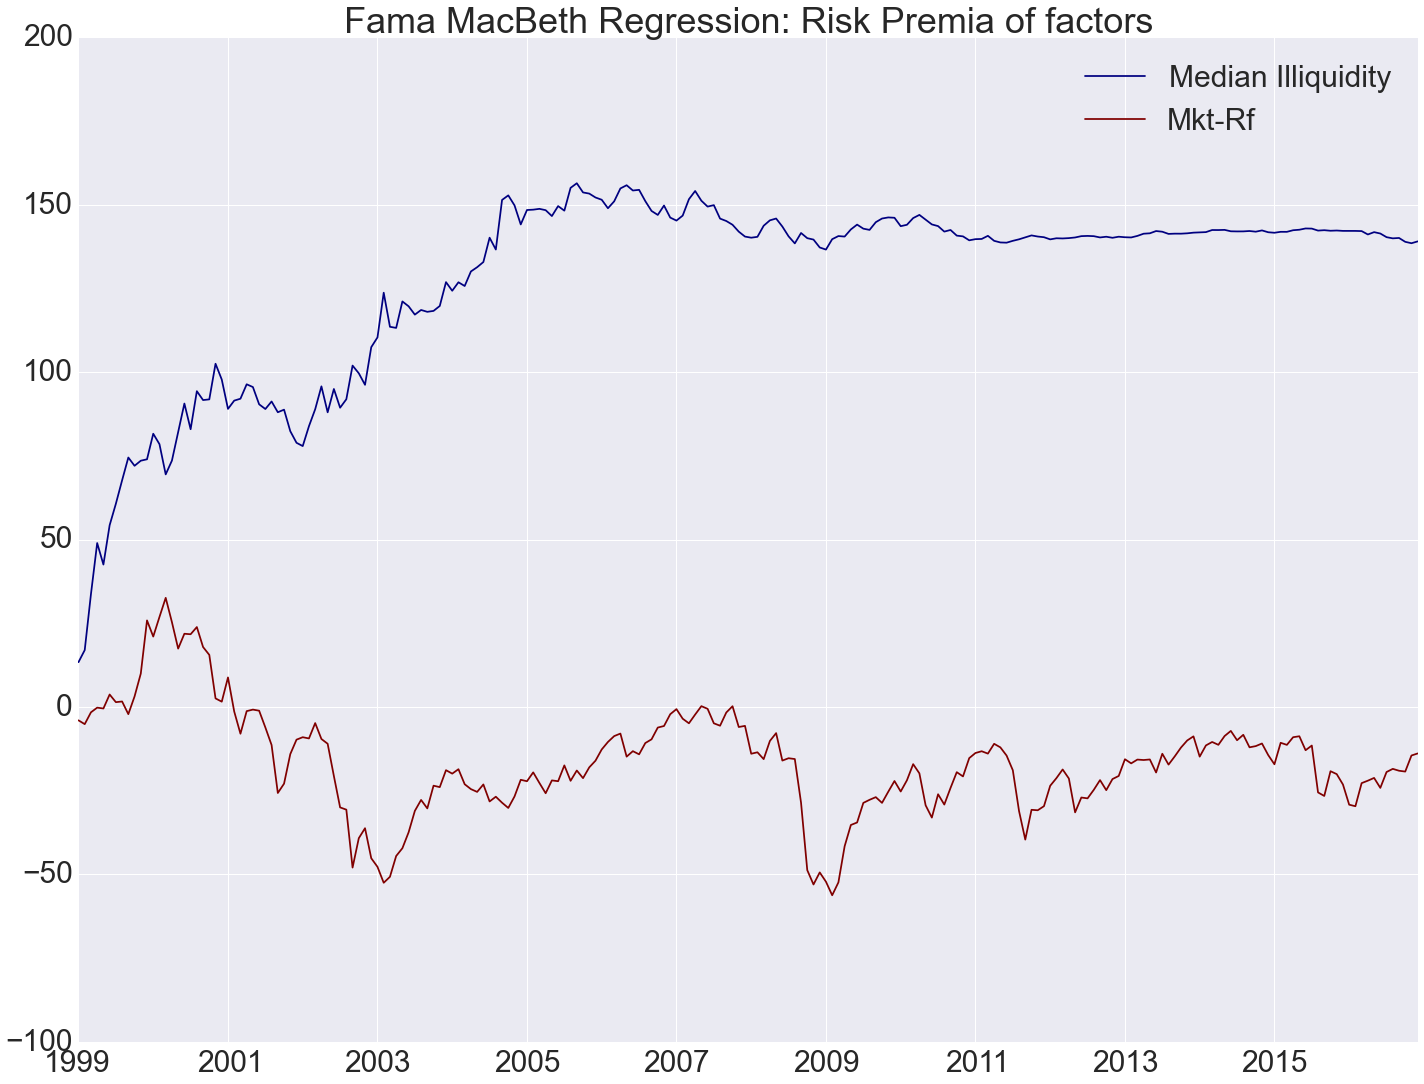

In [79]:
lambda_hat[factor_names].cumsum().plot(colormap='jet',title='Fama MacBeth Regression: Risk Premia of factors')